In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
#print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)

from parallel import Invoker

In [2]:
# Calculate params for simulations
from numpy import arange,linspace,logspace
import math

NUM_SIMULATED_CORES = 16
STATIC_NUM_FUNCTIONS = 16
LIB_FRACTION = 0.25
F_STEP = 2
#FunctionRange = arange(2,NUM_SIMULATED_CORES+F_STEP,F_STEP) # interval is open
FunctionRange = [16]
workset_range = [20,40,64,128]
GroupingRange = logspace(base=2,start=0,stop=4,num=5)

def divisorGenerator(n):
    large_divisors = []
    for i in range(1, int(math.sqrt(n) + 1)):
        if n % i == 0:
            yield i
            if i*i != n:
                large_divisors.append(n / i)
    for divisor in reversed(large_divisors):
        yield divisor
            
def filter_configs_by_cores(num_funcs,grouping,divisor_list):
    num_queues = num_funcs / grouping
    if num_queues in divisor_list:
        return True
        return (num_funcs,grouping,cores_per_q)
    
# Cores_per_q is always even for now by virtue of filter_configs_by_cores
def setup_final_config(num_funcs,grouping,workset,affinity=False,ideal=False):
    num_queues = num_funcs / grouping
    cores_per_q = NUM_SIMULATED_CORES / num_queues
    return {'funcs': int(num_funcs), 'grouping' : int(grouping), 'workset' : workset,
            'cores_per_q': int(cores_per_q), 'affinity' : affinity, 'ideal' : ideal}
    
# Find best grouping model for a given working set
def best_grouping(WorkingSet,core_divisors):
    unique_working_set = math.floor(WorkingSet * 1024 * (1-LIB_FRACTION))
    num_insts = unique_working_set/4
    num_branches = num_insts/5
    funcs_per_btb = math.floor(6*1024 / float(num_branches))
    
    largest_group = 1
    for x in core_divisors:
        if x > largest_group and x <= funcs_per_btb:
            largest_group = x
    
    return largest_group

core_divisors = list(divisorGenerator(NUM_SIMULATED_CORES))
best_groupings = [(best_grouping(w,core_divisors),w) for w in workset_range]
final_params = list(map(lambda x : setup_final_config(STATIC_NUM_FUNCTIONS,x[0],x[1]),best_groupings))

#iterator_combinations = ((fr,gr) for fr in FunctionRange for gr in GroupingRange)
#possible_combos = filter(lambda x : filter_configs_by_cores(x[0],x[1],core_divisors), iterator_combinations)
#final_params = list(map(lambda x : setup_final_config(x[0],x[1]), possible_combos)) 
    # instantiate the list so we don't run this cell repeatedly
    
# Add affinity solution to list of params
affinity_params = list(map(lambda x : setup_final_config(STATIC_NUM_FUNCTIONS,1,x,affinity=True),workset_range))
final_params.extend(affinity_params)

# Add theoretical best 99th% solution to list of params
# - 1 queue, 16 workers, ideal service time
ideal_args = list(map(lambda x : setup_final_config(STATIC_NUM_FUNCTIONS,STATIC_NUM_FUNCTIONS,x,affinity=False,ideal=True),workset_range)) 
    # 0 working set = ideal serv. time
#print([ideal_args])
final_params.extend(ideal_args)

In [3]:
#### Run simulations for various function numbers and various function grouping
def setup_sim(func_group,core_group,num_functions,load_range,workset,affinity,ideal):
    invokerArgs = {'runnableTarg' : 'qmodel_dispatch_nonuniform',
                  'mode': 'sweep_A',
                  'numProcs' : 24,
                  'NumWorkers' : NUM_SIMULATED_CORES,
                   'argrange': load_range,
                   'NumFunctions': num_functions,
                   'FunctionGrouping': func_group,
                   'CoreGrouping': core_group,
                   'WorkingSet' : workset*1024,
                   'RequestsToSimulate': 200000,
                  }
    if affinity is True:
        invokerArgs['UseAffinity'] = ''
    if ideal is True:
        invokerArgs['UseIdealSetup'] = ''
    return invokerArgs

import pandas

from components.zipf_gen import ZipfKeyGenerator
from random import shuffle
# Return a pandas dataframe with all results
def run_sims(func_group,core_group,num_functions,load_range,workset,affinity,ideal):
    args = setup_sim(func_group,core_group,num_functions,load_range,workset,affinity,ideal)
    
    # Add to dictionary the function popularities assumed (use a zipf for now)
    zargs = { 'num_items' : num_functions, 'coeff' : 0.5}
    zgen = ZipfKeyGenerator(**zargs)
    pdf_array = [ zgen.prob_for_rank(i) for i in range(num_functions) ]
    shuffle(pdf_array)
    
    def make_string_from_pop_list(l):
        ostring = ""
        for x in l:
            ostring += str(x) + " "
        return ostring
    args['FuncPopularities'] = make_string_from_pop_list(pdf_array)
    simulationController = Invoker( **args )
    print('Starting simulation for (Nf,G)=(',num_functions,',',func_group,')')
    simulationController.startProcs()
    simulationController.joinProcs()
    # Get results
    numProcs = args['numProcs']
    
    results = [ simulationController.getResultsFromQueue(idx) for idx in range(numProcs) ]
    flat_results = [ y for x in results for y in x ]
    
    # Remap results to the following format to import to pandas
    # { 'loads' : [ list of data points ]
    #    <Percentile Value> : [ list of data points ]
    # }
    def add_key_or_append(d,k,v):
        if k in d.keys():
            d[k].append(v)
        else:
            d[k] = []
            
    remap_dict = {}
    
    for x in flat_results:
        for load,times in x.items():
            load_mrps = 1/(load*1e-9)/1e6
            remap_dict[load_mrps] = times
    sorted_dict = {k:v for k,v in sorted(remap_dict.items(),key=lambda x : x[0])}
    f_dict = {}
    
    for load,time_dict in sorted_dict.items():
        # Append all loads to dict
        add_key_or_append(f_dict,'load',load)
        for p,v in time_dict.items():
            add_key_or_append(f_dict,str(p),v)      

    return args,pandas.DataFrame.from_dict(f_dict)

from numpy import linspace,logspace
### Run a group of simulations for each pair of num_functions/function_groupings
load_range = logspace(start=2,stop=4,base=10,num=50)
#print(load_range)

### Setup simulations for static policies
sims_gen = list(map(lambda x : run_sims(x['grouping'],x['cores_per_q'],x['funcs'],load_range,x['workset'],x['affinity'],x['ideal']),final_params))

Initializing harmonic sums...
Initializing pdf and cdf arrays....
Done!
Starting simulation for (Nf,G)=( 16 , 8 )
Simulation was unstable, last five service times from core 0 were: [100271.27025528578, 100635.38924169412, 101443.40852641442, 101743.02129904646] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100717.58071879914, 100758.88131530935, 101206.55260567312, 101822.58398945926] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100487.97879532457, 101377.55488062359, 101300.35085798154, 101723.13662775344] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101040.52204497062, 102335.76265857922, 102555.40976374396, 103747.84041339881] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100290.53513643332, 100375.67561925203, 100383.25689628534, 101491.59746625088] , killing sim.
Initializing harmonic sums...
Initializing pdf and cdf arrays....
Done!

Simulation was unstable, last five service times from core 0 were: [103731.66850493246, 106743.6171546384, 102482.64667530236, 100439.56096988576] , killing sim.
Caught exception <Process(run) object at 0x7f45f0957828> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101058.17782664, 106384.50822551816, 107957.5037796535, 113733.93967912313] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102696.15455556865, 108479.79816907356, 113885.22567870302, 116995.06777710057] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100535.5335577421, 105397.4289218249, 104977.7563817627, 106762.27469230244] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103487.49556725565, 109765.80217361814, 115103.9561408934, 120170.32435900005] , killing sim.
Simulation was unstable, last five service times from core 0 were:

Simulation was unstable, last five service times from core 0 were: [101612.2191892092, 101619.47200276842, 104894.05699958937, 100383.34425938202] , killing sim.
Caught exception <Process(run) object at 0x7f45f06ed630> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104164.07121825164, 103836.39514335952, 109582.81829348669, 115386.3185289984] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100760.55720634328, 101647.8042640826, 103142.92602429501, 108776.71756234215] , killing sim.
Caught exception <Process(run) object at 0x7f45f06ed630> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100800.45275838199, 105293.95102088217, 109016.36337665326, 112707.62087707629] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101233.63056734522, 102270.

Simulation was unstable, last five service times from core 0 were: [105057.75431259398, 109966.78923581568, 116460.53264006026, 122641.84942822636] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958438> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104746.73482492092, 110642.12580306182, 115300.87147526354, 121512.46456663853] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958438> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102424.69855551273, 104259.86366661094, 110134.11260228712, 115900.31536169769] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958438> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101857.20881522188, 107444.04373376991, 112677.18536066872,

Initializing harmonic sums...
Initializing pdf and cdf arrays....
Done!
Starting simulation for (Nf,G)=( 16 , 1 )
Simulation was unstable, last five service times from core 0 were: [102315.19599603329, 113629.78472660862, 120432.29903727348, 131106.66406258868] , killing sim.
Simulation was unstable, last five service times from core 0 were: [110024.29705698075, 122637.37045409114, 133632.60630626092, 146800.8645306196] , killing sim.
Caught exception <Process(run) object at 0x7f45f09579b0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100060.40664099352, 111288.64710559667, 121510.25090724853, 134963.78964978424] , killing sim.
Caught exception <Process(run) object at 0x7f45f09579b0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [107838.96261109585, 109665.00947694611, 121678.94247631985, 132330.8169022

Simulation was unstable, last five service times from core 0 were: [109205.55614174576, 107446.93526747613, 114746.1774280447, 126574.13233974142] , killing sim.
Caught exception <Process(run) object at 0x7f45f0954da0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0957a58> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0957ba8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f09579b0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101712.42402215491, 114520.39011427325, 117340.42474272763, 128213.98562085006] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102023.11830850726, 110269.45341183328, 123712.71289008795, 137326.58797914715] , killing sim.


Caught exception <Process(run) object at 0x7f45f0957a58> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [111265.73195334307, 119292.54410993031, 130785.01912008105, 129678.99993201278] , killing sim.
Simulation was unstable, last five service times from core 0 were: [110802.62252090727, 121187.49016973241, 134319.48936926905, 139122.0447091757] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100322.33504190095, 111366.65489634205, 120108.24784816653, 132810.6511539658] , killing sim.
Simulation was unstable, last five service times from core 0 were: [108258.88656636479, 106376.98069453615, 104209.87898043863, 114580.46676494706] , killing sim.
Caught exception <Process(run) object at 0x7f45f0957b00> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06ee080> has terminated and cannot be interrup

Simulation was unstable, last five service times from core 0 were: [107941.52356585447, 116364.91377991291, 129447.78454446406, 142377.9913839932] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104017.08217143283, 117615.01989700789, 129518.53366147248, 137269.1940768342] , killing sim.
Caught exception <Process(run) object at 0x7f45f0957b00> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06ee080> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101972.24533760284, 110011.7133183894, 116680.42615955576, 128086.12430920432] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958a20> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105239.71707742536, 114760.93848839168, 123009.442267217, 1357

Simulation was unstable, last five service times from core 0 were: [112122.25684035613, 125383.74007506955, 132934.60330603056, 146383.89788318094] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102706.3999694821, 110295.36600558074, 123526.12775787275, 136514.49833502853] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101797.9730587739, 108236.83921690966, 119008.4994848329, 116850.23188400429] , killing sim.
Caught exception <Process(run) object at 0x7f45f095f518> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [107711.3468201505, 115390.23940745532, 108918.72984619631, 106646.48236394138] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958a20> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105223.4510805315, 115875.32

Simulation was unstable, last five service times from core 0 were: [101690.58101433206, 115020.53494463807, 128440.32662495672, 136133.47919137147] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104487.92655699792, 117502.52898119112, 127762.27514464942, 137518.85843687612] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106269.03396478255, 119886.15240862005, 129221.70007456324, 131360.5507040391] , killing sim.
Caught exception <Process(run) object at 0x7f45f06e9c88> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095f518> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f07067f0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06e7588> has terminated and cannot be interrupted. lets transparently ignore it


Caught exception <Process(run) object at 0x7f45f0710c18> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [111791.13164719373, 125377.84821732128, 137659.85976821554, 149739.09306410328] , killing sim.
Caught exception <Process(run) object at 0x7f45f06eb7f0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f07030b8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109254.43473075311, 119064.29436527117, 132490.51692859724, 146121.6350384343] , killing sim.
Caught exception <Process(run) object at 0x7f45f0710c18> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100720.16690574907, 109490.56428760449, 109352.16342510737, 121631.28665606295] , killing sim.


Caught exception <Process(run) object at 0x7f45f095f0f0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109154.61599078514, 122064.78215008305, 134026.81248517372, 141627.0609843302] , killing sim.
Caught exception <Process(run) object at 0x7f45f07030b8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100190.09374198358, 112588.05849397264, 124651.51217159172, 130512.21784124017] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103778.25029550742, 114591.61806025694, 110571.48657202888, 120761.94483231174] , killing sim.
Caught exception <Process(run) object at 0x7f45f0710c18> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095f0f0> has terminated and cannot be interrupted. lets transparently ignore it


Simulation was unstable, last five service times from core 0 were: [105834.21946988377, 114638.72973268697, 126506.3401345844, 138485.95208428008] , killing sim.
Caught exception <Process(run) object at 0x7f45f06ddf28> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101642.70781392866, 111342.90233949223, 124772.61318123288, 133936.47666482048] , killing sim.
Caught exception <Process(run) object at 0x7f45f06ddf28> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100061.88960996855, 110438.32766736028, 122803.51288018002, 133275.8657093985] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103522.01069784116, 115315.44766073077, 128701.70125294635, 141706.79012653694] , killing sim.
Caught exception <Process(run) object at 0x7f45f06ab9e8> has terminated and cannot be interrup

Caught exception <Process(run) object at 0x7f45f0958d68> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100161.56616684813, 113361.44193927382, 126651.17217428001, 135204.01945174544] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958d68> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [106090.17496673328, 114730.57439598063, 128176.62457341203, 140494.18773268623] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958d68> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [113452.07144344071, 126564.43193768112, 135565.9667295332, 148219.04537536597] , killing sim.
Caught exception <Process(run) object at 0x7f45f0958d68> has terminated and cannot be interrupted. lets transparently ignore it


Caught exception <Process(run) object at 0x7f45f0948b00> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100124.31077176204, 102110.7203168677, 100749.5010314096, 102119.27976613608] , killing sim.
Caught exception <Process(run) object at 0x7f45f0948b00> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103505.34083780239, 103872.47680537598, 105803.09603599287, 109118.13038196006] , killing sim.
Caught exception <Process(run) object at 0x7f45f0948b00> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102572.48305887259, 105705.52481749513, 108607.93124780712, 107977.58196513902] , killing sim.
Caught exception <Process(run) object at 0x7f45f0948b00> has terminated and cannot be interrupted. lets transparently ignore it
S

Simulation was unstable, last five service times from core 0 were: [103273.13537461452, 106839.05603464169, 110348.01532012236, 108745.81296622101] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952860> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102853.53923952008, 106331.2814232877, 110005.33317577316, 110913.61165127368] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952860> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101606.51945296825, 105978.79833586275, 105908.23060535558, 108364.23143428883] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952860> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101890.28203397257, 102845.31462713088, 107289.97296944537, 

Caught exception <Process(run) object at 0x7f45f0944b38> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101694.48076235049, 104691.72231759748, 106444.92513065226, 103594.16176387435] , killing sim.
Caught exception <Process(run) object at 0x7f45f0944b38> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101171.31753966375, 103065.22157783108, 103347.9530571464, 100548.87453086732] , killing sim.
Caught exception <Process(run) object at 0x7f45f0944b38> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102162.89543973783, 101167.78857056121, 101649.85626447608, 101628.87761134782] , killing sim.
Caught exception <Process(run) object at 0x7f45f0944b38> has terminated and cannot be interrupted. lets transparently ignore it


Caught exception <Process(run) object at 0x7f45f0952470> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102208.50790435477, 108323.7554737687, 116648.29003543303, 124062.25000409185] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102634.64645370515, 102025.68400440412, 109825.78263754377, 110750.71949706881] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952518> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0952470> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101672.49290166165, 107685.80530916162, 113701.46345214442, 120721.91232686579] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952518> has terminated and cannot be interrupted. lets transparently ignore it


Caught exception <Process(run) object at 0x7f45f0952400> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102831.58434501731, 104718.78494677675, 111619.54399084934, 119761.31182411897] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952400> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101684.91331489058, 107796.91526128926, 114717.47311883504, 121851.06658697067] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952400> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105830.24586036103, 112693.2608494931, 114290.71089959152, 123653.82750222445] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952400> has terminated and cannot be interrupted. lets transparently ignore it


Simulation was unstable, last five service times from core 0 were: [101031.74697947712, 108527.92772784486, 115378.47271231032, 120087.9346269943] , killing sim.
Caught exception <Process(run) object at 0x7f45f0701240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [107852.84837496499, 111961.3713317049, 118861.90412742287, 126208.63377310161] , killing sim.
Caught exception <Process(run) object at 0x7f45f0701240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104276.1661990484, 112556.98151397411, 119040.26438760235, 126866.74641077322] , killing sim.
Caught exception <Process(run) object at 0x7f45f0701240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [107764.28998757617, 115886.06428611786, 123352.71055934421, 13

Caught exception <Process(run) object at 0x7f45f09528d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [106273.1330526188, 109487.56979697304, 111146.67294802208, 120470.49294938573] , killing sim.
Caught exception <Process(run) object at 0x7f45f09528d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104096.34591694314, 113191.66923726152, 117603.8714665232, 122988.80737518] , killing sim.
Caught exception <Process(run) object at 0x7f45f09528d0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [106810.61772172597, 105867.44102229692, 112947.46560431363, 120730.321622259] , killing sim.
Caught exception <Process(run) object at 0x7f45f09528d0> has terminated and cannot be interrupted. lets transparently ignore it
Simula

Simulation was unstable, last five service times from core 0 were: [105385.38840792174, 106848.95421071962, 116284.58758360951, 117625.56885953361] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943ba8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102548.37983735238, 105607.81222289281, 113735.32529345345, 121528.52400760073] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943ba8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105728.52810973153, 107031.407825865, 115235.04647725381, 117567.63716133579] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943ba8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103460.99331875147, 111164.12518015798, 118589.77172133295, 1

Caught exception <Process(run) object at 0x7f45f0943be0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103656.13880273208, 104961.96152698841, 113192.86016260796, 122613.38363693768] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943be0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101518.05499341126, 109434.81526407899, 116471.69342933325, 119675.75394669478] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943be0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102044.95808285088, 109521.68058447508, 116387.19176259887, 120356.34953579132] , killing sim.
Caught exception <Process(run) object at 0x7f45f0943be0> has terminated and cannot be interrupted. lets transparently ignore it

Caught exception <Process(run) object at 0x7f45f0952f98> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101055.8620525822, 106106.3084518686, 108413.60319355875, 111451.20197985321] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102746.320112966, 103662.04734618962, 107936.30265475065, 106963.17723644525] , killing sim.
Caught exception <Process(run) object at 0x7f45f0948dd8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102463.42837626487, 108639.94177247584, 108717.06540834904, 111833.65964027494] , killing sim.
Caught exception <Process(run) object at 0x7f45f0948dd8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101459.69614446908, 107940.72877912968, 108464.19035378098, 113

Caught exception <Process(run) object at 0x7f45f0952cf8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103866.62339367237, 116580.00043337082, 128602.23155462064, 142145.0212933736] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100715.1560013824, 112511.90197605903, 121460.76970266893, 134914.16973893333] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100624.64961919296, 111828.41385945075, 123859.13733091255, 126957.68957894472] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952cc0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0952c18> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [106448.09588507627, 116262.01961140458, 121464.04357180717, 1

Simulation was unstable, last five service times from core 0 were: [101790.37099271714, 112739.75969210899, 118554.33982154846, 130165.06464847522] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106766.78464634561, 120104.92586608353, 131932.06932844422, 138637.76914727903] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952c18> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103924.38311837605, 111466.72410908609, 122925.81934621146, 136779.40147179618] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101134.50543511809, 103600.63753870515, 106373.48422872183, 115975.28950852786] , killing sim.
Caught exception <Process(run) object at 0x7f45f0952cc0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0952c50> has terminated and cannot be interr

Caught exception <Process(run) object at 0x7f45f0953da0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0953ef0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0952c50> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102798.56566864613, 112842.87494577777, 127449.64595008703, 136687.088388486] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103925.4228806282, 114732.56568246192, 126923.90896030283, 141492.41236587125] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106163.95932193946, 115632.20126185787, 121683.65228747956, 121646.92593722211] , killing sim.
Caught exception <Process(run) object at 0x7f45f0953da0> has terminated and cannot be interrupted. lets transparently ignore it
Ca

Caught exception <Process(run) object at 0x7f45f0704240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103296.69192078518, 116687.23168755928, 126719.54205747013, 140329.6331832744] , killing sim.
Caught exception <Process(run) object at 0x7f45f0704240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103810.88054036986, 113735.29606216293, 111471.16916239428, 111497.7995068327] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100745.75909890415, 110132.91940300276, 123075.12615999657, 133939.43970404562] , killing sim.
Simulation was unstable, last five service times from core 0 were: [109680.30783600219, 114136.2169147824, 120113.53870160878, 133505.8506991643] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106425.4475561084, 116888.80

Simulation was unstable, last five service times from core 0 were: [103873.65614230427, 114086.20493235154, 119943.05010815545, 124567.92921594734] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104998.34080887777, 113279.691344459, 120056.74632448531, 129147.22885776966] , killing sim.
Caught exception <Process(run) object at 0x7f45f0710630> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0704240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104863.8629117989, 103668.50218523924, 110293.6969286476, 121358.31485009538] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101793.19817933507, 115259.73642405205, 127515.79208207337, 140

Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0710630> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095c978> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0700208> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f07074a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [112448.44622812847, 116450.28687484024, 128610.1046615437, 135454.95007119002] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106929.57083108841, 119769.28537038757, 132768.58933795663, 143299.99088425768] , killing sim.
Simulation was unstable, last five 

Simulation was unstable, last five service times from core 0 were: [106077.23936028287, 116670.18055866152, 129805.87808520594, 142857.23715411677] , killing sim.
Caught exception <Process(run) object at 0x7f45f07074a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [108849.61102299255, 122272.85260294042, 133564.04720780425, 146198.5766940728] , killing sim.
Caught exception <Process(run) object at 0x7f45f07074a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [109988.53227373575, 123151.68205999455, 133772.66270787784, 147183.44628190147] , killing sim.
Caught exception <Process(run) object at 0x7f45f07074a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [113293.1087196308, 127440.17030911033, 141146.12895242652, 1

Caught exception <Process(run) object at 0x7f45f095b4a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [110905.24611473102, 113121.60464713232, 126532.30144641343, 133307.5192765029] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b4a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [106366.2962893187, 115318.8856809089, 122473.04174884601, 136499.66379843943] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b4a8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [112762.86279315047, 115378.80484703124, 127948.22637515026, 137739.11796919303] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b4a8> has terminated and cannot be interrupted. lets transparently ignore it
Si

Simulation was unstable, last five service times from core 0 were: [102390.1376444372, 116620.15230238595, 129600.94305729971, 142396.8016760621] , killing sim.
Caught exception <Process(run) object at 0x7f45f095c7f0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102522.3148217045, 116749.46857609448, 129697.86711547276, 142617.53821815687] , killing sim.
Caught exception <Process(run) object at 0x7f45f095c7f0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103939.96769855233, 118168.88570993945, 130700.27463551376, 143241.6589164782] , killing sim.
Caught exception <Process(run) object at 0x7f45f095c7f0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104750.2023393521, 118797.84589678666, 133879.89687492818, 1466

Caught exception <Process(run) object at 0x7f45f06a4908> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104412.96847520214, 116605.25106782201, 129682.87555171165, 143649.62973402455] , killing sim.
Caught exception <Process(run) object at 0x7f45f06a4908> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103433.8580568935, 118463.7500396006, 131061.93952401206, 144835.08758006035] , killing sim.
Caught exception <Process(run) object at 0x7f45f06a4908> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [110177.5914614248, 124428.79317406542, 138121.72940974383, 143736.62948661402] , killing sim.
Caught exception <Process(run) object at 0x7f45f06a4908> has terminated and cannot be interrupted. lets transparently ignore it
Si

Simulation was unstable, last five service times from core 0 were: [101162.82466609048, 114569.34737510778, 131501.78284458898, 158190.82359296153] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104238.55387178922, 115821.508683295, 137236.75165387633, 164152.5210551945] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100107.93879207883, 113562.91139585203, 138130.9659483097, 165264.72853659856] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [100709.15899604086, 113210.35094403084, 139070.34600610647, 166566.71557940947] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupte

Caught exception <Process(run) object at 0x7f45f095b278> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101539.7069684315, 114021.14190016387, 127860.11953678953, 153771.14586666026] , killing sim.
Simulation was unstable, last five service times from core 0 were: [107825.90405635876, 137629.3829801011, 134198.20827657607, 146512.15413906495] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102034.82447342234, 113727.30388019118, 133790.4179174822, 156343.13989902276] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b390> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095a588> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [120317.23891879297, 147794.8377734329, 174378.7513984077, 2022

Caught exception <Process(run) object at 0x7f45f095b358> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [105463.74896180152, 125272.60753682112, 148866.0221731701, 175612.76635602236] , killing sim.
Simulation was unstable, last five service times from core 0 were: [106789.7116478256, 118532.62092540879, 146149.6660846008, 165597.0209731447] , killing sim.
Simulation was unstable, last five service times from core 0 were: [113468.96358282135, 121416.13885495921, 147772.4867478324, 166458.0454339339] , killing sim.
Simulation was unstable, last five service times from core 0 were: [109685.6231964289, 127016.38838804913, 151224.59481417743, 179269.83640219166] , killing sim.
Simulation was unstable, last five service times from core 0 were: [116755.26095626538, 144356.9484776425, 152116.92236246064, 182157.5540376484] , killing sim.
Caught exception <Process(run) object at 0x7f45f095a710> has termi

Caught exception <Process(run) object at 0x7f45f095a710> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103746.26693009304, 110729.13504806429, 134519.4208257671, 161853.1575992079] , killing sim.
Simulation was unstable, last five service times from core 0 were: [111905.79209714037, 135320.93967950728, 161505.58047917485, 187565.52250173653] , killing sim.
Simulation was unstable, last five service times from core 0 were: [108755.58730832985, 126419.01474940655, 149037.78348369402, 174993.80006666025] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b438> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095b390> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095a7f0> has terminated and cannot be interrupted. lets transparently ignore it
C

Simulation was unstable, last five service times from core 0 were: [107224.65317771761, 131977.97956952892, 157262.44022874517, 178405.3212872857] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b390> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [126373.81562986493, 146836.24094859944, 172715.47883829064, 197865.3089157395] , killing sim.
Caught exception <Process(run) object at 0x7f45f095bb38> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [112910.72904487952, 118590.79492047723, 116142.13917644526, 118043.9195017775] , killing sim.
Simulation was unstable, last five service times from core 0 were: [109925.61637498885, 131235.96847483554, 151387.89587844373, 171882.81304800004] , killing sim.
Caught exception <Process(run) object at 0x7f45f095a710> has terminated and cannot be interrupt

Caught exception <Process(run) object at 0x7f45f095a940> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [119974.3652012723, 147659.59504600515, 151824.50062553433, 179144.79644531658] , killing sim.
Simulation was unstable, last five service times from core 0 were: [127999.69660382134, 152995.64811404422, 179001.96569020578, 205724.06039883528] , killing sim.
Simulation was unstable, last five service times from core 0 were: [108095.10470200022, 101958.91337296419, 121802.85151875362, 139311.08240654046] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b390> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [123196.78797655893, 140686.74051613727, 137717.89084871707, 145311.35365912362] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102671.12877371878, 13040

Simulation was unstable, last five service times from core 0 were: [100070.46134760168, 108885.7434860967, 120607.621500444, 149613.34999701657] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101670.72017810575, 121487.87930954256, 141378.06519698384, 154948.6909613863] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b240> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103225.27864768871, 132948.96454643982, 144563.6427642894, 156224.12287224917] , killing sim.
Caught exception <Process(run) object at 0x7f45f095a940> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [103177.68359269423, 132923.1351075632, 160160.4332437295, 187921.1460861304] , killing sim.
Caught exception <Process(run) object at 0x7f45f095bc50> has terminated and cannot be interrupted. l

Caught exception <Process(run) object at 0x7f45f095bc50> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095bcf8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101515.48581248993, 111170.99536745975, 115224.99153592126, 143077.91296196365] , killing sim.
Simulation was unstable, last five service times from core 0 were: [108932.79926298803, 103057.08692811581, 113130.08128448285, 127158.70808788016] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101716.7563730072, 111549.89532669552, 132452.21970897552, 151657.30340964237] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101502.4197239774, 128425.31841111479, 158049.73812887626, 186012.80230377454] , killing sim.
Caught exception <Process(run) object at 0x7f45f095bcf8> has terminated and cannot be interrup

Caught exception <Process(run) object at 0x7f45f095bc50> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06ea4a8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095a780> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095bcf8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [120373.54392547847, 150247.73085861382, 156928.44853213357, 182706.80907477485] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101542.04188250753, 118418.74928848504, 146988.18589024575, 165113.80983507144] , killing sim.
Simulation was unstable, last five service times from core 0 were: [102363.16267687574, 115234.58873770692, 124746.42683430108, 153580.32496262412] , killing sim.

Simulation was unstable, last five service times from core 0 were: [100015.60849629433, 129431.17190863262, 118599.30896681835, 117968.88690986487] , killing sim.
Simulation was unstable, last five service times from core 0 were: [111380.1378617314, 132625.61825185342, 158699.87011685103, 182639.65047245985] , killing sim.
Simulation was unstable, last five service times from core 0 were: [120786.83973313359, 130686.75454477106, 154637.98281008803, 171306.22091666283] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104256.24339610901, 133815.56564204305, 162234.8371528257, 190934.5051283355] , killing sim.
Caught exception <Process(run) object at 0x7f45f06e10b8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06f6eb8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095a780> has terminated and cannot be interrupt

Caught exception <Process(run) object at 0x7f45f06e10b8> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [102133.66526595181, 132317.74509652972, 153623.26139276242, 182430.3852563925] , killing sim.
Caught exception <Process(run) object at 0x7f45f095bbe0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [108832.84443477822, 129939.16971824793, 157753.31040591554, 178579.2241100768] , killing sim.
Caught exception <Process(run) object at 0x7f45f095abe0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [114563.43243915326, 144213.00493852317, 134840.7218252945, 148787.41240743452] , killing sim.
Caught exception <Process(run) object at 0x7f45f0718198> has terminated and cannot be interrupted. lets transparently ignore it
Si

Simulation was unstable, last five service times from core 0 were: [114186.58110958706, 134901.085881516, 152880.93618834962, 181834.45593594672] , killing sim.
Simulation was unstable, last five service times from core 0 were: [111275.35775338237, 132268.86522395842, 152482.2025998287, 179147.4214636731] , killing sim.
Caught exception <Process(run) object at 0x7f45f095abe0> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0718198> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06e10b8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095af60> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104322.41054763898, 117202.41250726717, 128439.67143343051, 155192.7640979399] , killing sim.
Simu

Caught exception <Process(run) object at 0x7f45f0704c18> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f0718198> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095af60> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f095abe0> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [111119.8033540413, 137760.98783905338, 145944.6834078075, 176014.7334994407] , killing sim.
Simulation was unstable, last five service times from core 0 were: [124818.0243382702, 148858.6703581255, 169086.2609978529, 196299.97214582778] , killing sim.
Caught exception <Process(run) object at 0x7f45f0704c18> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five servi

Caught exception <Process(run) object at 0x7f45f06a0e48> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [101036.46970956537, 131056.57307203769, 149602.25693573852, 176201.49429034186] , killing sim.
Simulation was unstable, last five service times from core 0 were: [103525.27657117, 132519.0108888685, 156235.0278561375, 184129.31823608454] , killing sim.
Caught exception <Process(run) object at 0x7f45f0708cf8> has terminated and cannot be interrupted. lets transparently ignore it
Caught exception <Process(run) object at 0x7f45f06a0e48> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [104051.03841603934, 134004.18286342305, 153551.95011878424, 181416.0829106741] , killing sim.
Simulation was unstable, last five service times from core 0 were: [104129.8138767132, 133158.6817009719, 157915.29139489055, 186021.

Caught exception <Process(run) object at 0x7f45f095b320> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [114822.05083849088, 144041.86118862987, 172320.95152224408, 201153.4144931383] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b320> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [119342.58528850404, 147720.39192242306, 175263.2726950902, 203756.81595454385] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b320> has terminated and cannot be interrupted. lets transparently ignore it
Simulation was unstable, last five service times from core 0 were: [121072.65791233329, 150945.65949490742, 176984.29825781833, 205497.6597069879] , killing sim.
Caught exception <Process(run) object at 0x7f45f095b320> has terminated and cannot be interrupted. lets transparently ignore it
Si

Simulation was unstable, last five service times from core 0 were: [100299.44856559066, 101157.19561699498, 102363.78421264281, 102899.09067425737] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100309.04472813568, 103181.66258674428, 104911.62655346747, 107471.23914803086] , killing sim.
Simulation was unstable, last five service times from core 0 were: [100390.60349303529, 102778.7506277393, 104901.21766289216, 108099.46814775291] , killing sim.
Initializing harmonic sums...
Initializing pdf and cdf arrays....
Done!
Starting simulation for (Nf,G)=( 16 , 16 )
Simulation was unstable, last five service times from core 0 were: [101668.70198338723, 101894.47591963428, 104939.23702133726, 106802.86396236002] , killing sim.
Simulation was unstable, last five service times from core 0 were: [101622.38091292905, 106676.1895303741, 111336.38541629138, 116538.67407524702] , killing sim.
Simulation was unstable, last five service times from core 0 were: [1025

In [4]:
# Remap the list of results into two sub-lists
# static:
#   TOP LEVEL: {working set: {}}
#      SECOND LEVEL: {function grouping:{data}}

# affinity:
#   TOP LEVEL: {working set: {data}}

graph_us_static = {}
graph_us_affinity = {}
graph_us_ideal = {}
def init_or_add_val_twolevel(d,k,k2,v):
    if k not in d.keys():
        d[k] = {}
    if k2 not in d[k].keys():
        d[k][k2] = v
    else:
        print('WARN: WOULD HAVE OVERWRITTEN DATA')

def init_or_add_val(d,k,v):
    if k not in d.keys():
        d[k] = v
    else:
        print('WARN: WOULD HAVE OVERWRITTEN DATA')


for args,df in sims_gen:
    if 'UseAffinity' in args:
        init_or_add_val(graph_us_affinity,args['WorkingSet'],df)
    elif 'UseIdealSetup' in args:
        init_or_add_val(graph_us_ideal,args['WorkingSet'],df)
    else:
        tup_to_k2 = (args['FunctionGrouping'],args['CoreGrouping'])
        init_or_add_val_twolevel(graph_us_static,args['WorkingSet'],tup_to_k2,df)
        

In [5]:
# Import and setup
import matplotlib.pyplot as plt
import numpy
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
fontdir = {'size':16,'family':'serif'}
rc('font',**fontdir)
rc('text',usetex=True)

def backup_fname(fname):
    if os.path.exists(fname):
        print('Figure already exists with fname',fname,'will back up!')
        fname_bak = fname + '.bak'
        os.rename(fname,fname_bak)

Figure already exists with fname throughput_benefit_affinity.pdf will back up!


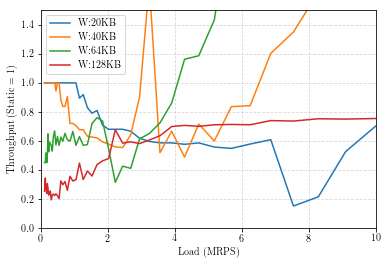

In [6]:
# Create the following graph
#   - a graph that shows the throughput benefits of locality-based over best static config
#   - one line for each working set
#
#      |
#      |
#  T   |
#      |
#      |----------------
#          load

fname_throughput = 'throughput_benefit_affinity.pdf'
backup_fname(fname_throughput)
with PdfPages(fname_throughput) as pp:
    f,axarr = plt.subplots(1,1)
    for workset,params_data in graph_us_static.items():
        if workset == 0: 
            continue
        # create new df comparing throughputs
        for tup,values in params_data.items():
            grouping = tup[0]
            cores_per_q = tup[1]
            num_queues = int(STATIC_NUM_FUNCTIONS / grouping)
            mathstring = r" $("+str(num_queues)+"\\times"+str(cores_per_q)+")$"
            w_int_kb = int(workset/1024)
            wstr = str(w_int_kb)+'KB'
            l = 'W:' + wstr

            # Get locality-based for same working set
            affinity_data = graph_us_affinity[workset]
            values['throughput_norm'] = values['50']/affinity_data['50']
            values.plot(x='load',y='throughput_norm',ax=axarr,label=l)
            
    axarr.grid(True,axis='both',linestyle='--',alpha=0.5)
    axarr.set_xlabel('Load (MRPS)')
    axarr.set_ylabel('Throughput (Static = 1)')
    axarr.set_xlim(0,10)
    axarr.set_ylim(0,1.5)
    pp.savefig()

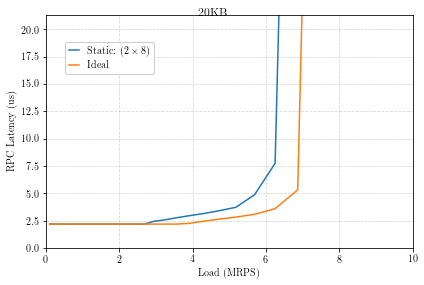

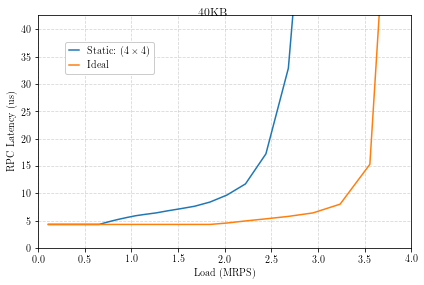

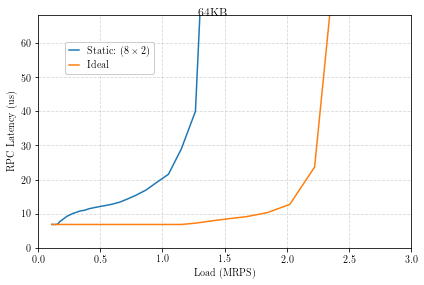

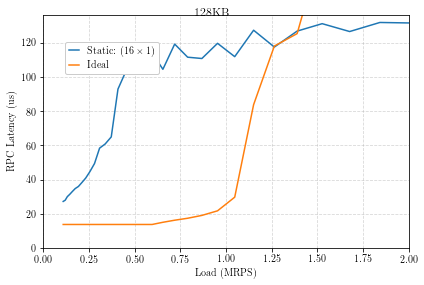

In [7]:
# Create the following graph:
# compare theoretical best (1x16) to the static based, showing problem w. 99th%
workset_xlims = { 20: 10 , 40: 4, 64 : 3, 128: 2 }
for wset, xlim in workset_xlims.items():
    w_int_kb = int(wset)
    wstr = str(w_int_kb)+'KB'
    calculate_ylim = w_int_kb*1024/4/1.2/2 # KB/ bytes/inst / IPC / cycles/ns
    calculate_ylim_10x = 10*calculate_ylim/1000
    fname_tail_lat = 'static_to_ideal_comparison'+wstr+'.pdf'
    backup_fname(fname_tail_lat)
    with PdfPages(fname_tail_lat) as pp:
        f,ax = plt.subplots(1,1)
        # Get data
        df_static = graph_us_static[wset*1024]
        df_ideal = graph_us_ideal[wset*1024] # only one value

        for tup,values in df_static.items():
            grouping = tup[0]
            cores_per_q = tup[1]
            num_queues = int(STATIC_NUM_FUNCTIONS / grouping)
            mathstring = r"Static: $("+str(num_queues)+"\\times"+str(cores_per_q)+")$"
            values.plot(x='load',y='99',ax=ax,label=mathstring)
        
        # Plot ideal
        df_ideal.plot(x='load',y='99',ax=ax,label='Ideal')

        ax.grid(True,axis='both',linestyle='--',alpha=0.5)
        ax.get_legend().remove()
        ax.set_ylim(0,calculate_ylim_10x)
        ax.set_xlim(0,workset_xlims[w_int_kb])
        ax.set_ylabel('RPC Latency (us)')
        ax.set_xlabel('Load (MRPS)')
            
        handles, labels = ax.get_legend_handles_labels()
        #f.legend(handles,labels,loc='upper left')
        f.legend(handles,labels,loc='upper left',
                 bbox_to_anchor=(0.14,0.86),ncol=1,fontsize=10,frameon=True,framealpha=1,
                handlelength=1,columnspacing=1)
        f.suptitle(wstr)
        f.tight_layout()
        pp.savefig()
        
    

Figure already exists with fname percentile_comparison_affinity_20KB.pdf will back up!
Figure already exists with fname percentile_comparison_affinity_40KB.pdf will back up!
Figure already exists with fname percentile_comparison_affinity_64KB.pdf will back up!
Figure already exists with fname percentile_comparison_affinity_128KB.pdf will back up!


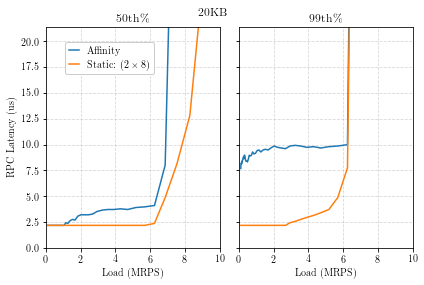

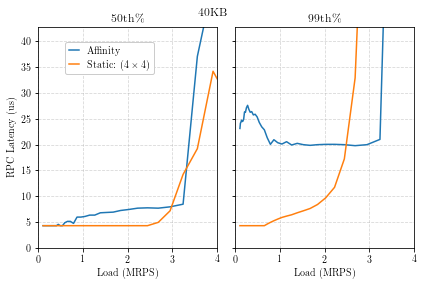

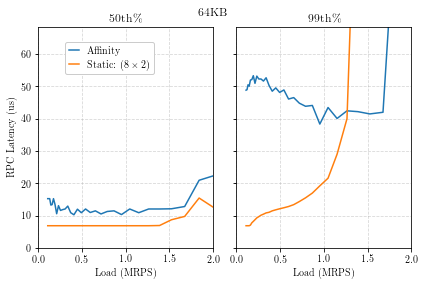

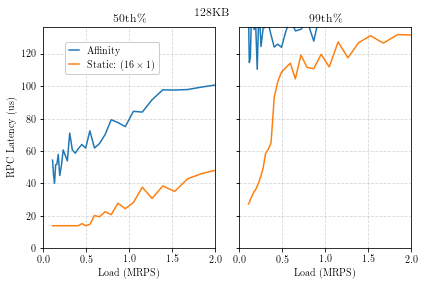

In [10]:
# Create the following graph:
# title of graph: working set
# for each percentile >= 90th, two lines: best static policy to affinity-based
percentiles = [50,99]
workset_xlims = { 20: 10 , 40: 4, 64 : 2, 128: 2 }
for wset,affinity_data in graph_us_affinity.items():
    w_int_kb = int(wset/1024)
    wstr = str(w_int_kb)+'KB'
    calculate_ylim = w_int_kb*1024/4/1.2/2 # KB/ bytes/inst / IPC / cycles/ns
    calculate_ylim_10x = 10*calculate_ylim/1000
    fname_tail_lat = 'percentile_comparison_affinity_'+wstr+'.pdf'
    backup_fname(fname_tail_lat)
    
    with PdfPages(fname_tail_lat) as pp:
        f,axarr = plt.subplots(1,len(percentiles),sharey=True)
        for i in range(len(percentiles)):
            pstr = str(percentiles[i])
            # Plot the load-lat for the affinity-based
            l = r"Affinity"
            affinity_data.plot(x='load',y=pstr,ax=axarr[i],label=l)
            axarr[i].set_title(pstr+'th\%')
            # On the same axis, plot the matching static policy
            for tup,values in graph_us_static[wset].items():
                grouping = tup[0]
                cores_per_q = tup[1]
                num_queues = int(STATIC_NUM_FUNCTIONS / grouping)
                mathstring = r"Static: $("+str(num_queues)+"\\times"+str(cores_per_q)+")$"
                values.plot(x='load',y=pstr,ax=axarr[i],label=mathstring)
                
        for i,ax in enumerate(axarr):
            ax.grid(True,axis='both',linestyle='--',alpha=0.5)
            ax.get_legend().remove()
            ax.set_ylim(0,calculate_ylim_10x)
            ax.set_xlim(0,workset_xlims[w_int_kb])
            ax.set_ylabel('RPC Latency (us)')
            ax.set_xlabel('Load (MRPS)')
            
        handles, labels = axarr[0].get_legend_handles_labels()
        f.legend(handles,labels,loc='upper left',bbox_to_anchor=(0.14,0.86),ncol=1,fontsize=10,frameon=True,framealpha=1,
            handlelength=1,columnspacing=1)
        f.suptitle(wstr)
        f.tight_layout()
        pp.savefig()